In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os
import copy
import holidays
import datetime as dt
from datetime import timedelta

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import multilabel_confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBClassifier, XGBRegressor
from scipy.stats import randint, uniform
import catboost as cb
import math
from imblearn.over_sampling import SMOTE, SVMSMOTE, KMeansSMOTE
from boruta import BorutaPy
from BorutaShap import BorutaShap

import shap

from shap_selection import feature_selection
shap.initjs()

pd.set_option('display.max_columns', 70)
pd.set_option('display.max_colwidth', None) #100 or None

os.getcwd()

'/Users/miek/Documents/DS4B/DS4BThesisSNCB'

## Import data

In [2]:
# read in punctuality data
punct2019_1 = pd.read_csv("./data/Punctuality_2019_part1.csv", sep = ";")
punct2019_2 = pd.read_csv("./data/Punctuality_2019_part2.csv", sep = ";")
punct2020_1 = pd.read_csv("./data/Punctuality_2020_part1.csv", sep = ";")
punct2020_2 = pd.read_csv("./data/Punctuality_2020_part2.csv", sep = ";")
punct2021_1 = pd.read_csv("./data/Punctuality_2021_part1.csv", sep = ";")
punct2021_2 = pd.read_csv("./data/Punctuality_2021_part2.csv", sep = ";")
punct2022_1 = pd.read_csv("./data/Punctuality_2022_part1.csv", sep = ";")
punct2022_2 = pd.read_csv("./data/Punctuality_2022_part2.csv", sep = ";")
punct2023 = pd.read_csv("./data/Punctuality_2023.csv", sep = ";")
all_punct = pd.concat([punct2019_1, punct2019_2, punct2020_1, punct2020_2, punct2021_1, punct2021_2, punct2022_1, punct2022_2, punct2023], axis = 0)
all_punct = all_punct[all_punct['TRAIN_ID'].notna()].reset_index()

In [3]:
# read in justifications data
justifs = pd.read_parquet("~/Downloads/justif_parquet")
justifs = justifs[justifs['TRAIN_ID_resp'].notna()]
justifs['p_resp'] = justifs['trno_resp'].apply(lambda x: 1 if ((x >= 7000) & (x <= 8999)) else 0)
# sort justifs by justification_dt
justifs = justifs.sort_values(by = ['justification_dt']).reset_index(drop = True)

In [4]:
# read in network data
network_char_example_trains = pd.read_csv('./data/network_char_example_trains_5mins_weighted.csv')
network_char_example_trains['TRAIN_NUMBER'] = network_char_example_trains['TRAIN_NUMBER'].astype(str) + '.0'

In [5]:
# read in stops data
df = pd.read_parquet("~/Downloads/all_stops_ungrouped/rush_comm_stops_post_covid.parquet")

## Getting the label

In [6]:
# get list of all resp. trains in the chain for every impacted train (takes ~25 mins)
def find_chain(row, df):
    impacted_train_id = row['REF_TOD_IMPACTED_TRAIN']
    responsible_train_id = row['TRAIN_ID_resp']
    justification_dt = row['justification_dt']

    # Initialize the list of responsible train IDs
    chain = [responsible_train_id]

    # Create a boolean mask for prior delays within 5 minutes
    mask = (df['justification_dt'] < justification_dt) & \
           (df['justification_dt'] >= justification_dt - timedelta(minutes=5)) & \
           (df['REF_TOD_IMPACTED_TRAIN'] == responsible_train_id)

    # Find the indices of prior delays that satisfy the mask
    prior_indices = np.where(mask)[0]

    # Iterate over the indices and recursively find the chain
    for idx in prior_indices:
        prior_row = df.iloc[idx]
        prior_chain = find_chain(prior_row, df)
        chain.extend(prior_chain)

    return chain

justifs['resp_chain'] = justifs.apply(lambda row: find_chain(row, justifs), axis=1)
justifs['resp_chain'] = justifs['resp_chain'].apply(lambda x: list(set(x)))
justifs[['REF_TOD_IMPACTED_TRAIN', 'TRAIN_ID_resp', 'trno_resp', 'justification_dt', 'resp_chain']]

,REF_TOD_IMPACTED_TRAIN,TRAIN_ID_resp,trno_resp,justification_dt,resp_chain
0,22626539,22628988.0,7716.0,2019-01-02 05:55:39,[22628988.0]
1,22631315,22631227.0,7301.0,2019-01-02 06:18:04,[22631227.0]
2,22631227,22631100.0,1728.0,2019-01-02 06:29:52,[22631100.0]
3,22628196,22629554.0,4677.0,2019-01-02 06:31:33,[22629554.0]
4,22628791,22630077.0,7400.0,2019-01-02 06:33:17,[22630077.0]
...,...,...,...,...,...
528943,32465273,32464825.0,7009.0,2023-05-03 09:05:16,[32464825.0]
528944,32465273,32464825.0,7009.0,2023-05-03 09:05:16,[32464825.0]
528945,32465273,32464825.0,7009.0,2023-05-03 09:05:16,[32464825.0]
528946,32463246,32465562.0,7629.0,2023-05-03 09:06:17,[32465562.0]


We assign the positive label (1) if any of the trains impacted by the P-train failed to meet the service level for punctuality (>= 6m delay)

In [7]:
# from all_punct get train_ids of trains that were non-punctual, left merge with justifs to keep only guilty trains
punct_justifs = justifs.merge(all_punct[['TRAIN_ID', 'Retard_1pointage_valeur']],
                              left_on='REF_TOD_IMPACTED_TRAIN',
                              right_on='TRAIN_ID',
                              how = 'left')

unique_values = set()
for resp_list in punct_justifs['resp_chain']:
    unique_values.update(resp_list)
unique_values = list(unique_values)

# make dictionary of train IDs and their respective train numbers
train_id_dict = dict(zip(justifs['TRAIN_ID_resp'], justifs['trno_resp']))

# match train IDs in 'resp_chain' to respective train numbers
punct_justifs['resp_chain_trno'] = punct_justifs['resp_chain'].apply(lambda x: [train_id_dict[i] for i in x])
punct_justifs[['REF_TOD_IMPACTED_TRAIN', 'resp_chain', 'resp_chain_trno']]

# remove trains we don't have punctuality data for
punct_justifs = punct_justifs[punct_justifs['Retard_1pointage_valeur'].notna()]

# make a split dataframe for grouping by train number purposes
def split_rows(df):
    df = df.set_index(['REF_TOD_IMPACTED_TRAIN'])[['resp_chain', 'resp_chain_trno']].apply(pd.Series.explode).reset_index()
    return pd.concat([df], ignore_index=True)

punct_justifs_copy = punct_justifs.copy()
punct_justifs_split = split_rows(punct_justifs_copy)
punct_justifs_split = punct_justifs_split.merge(punct_justifs[['REF_TOD_IMPACTED_TRAIN', 'Retard_1pointage_valeur']],
                                                on = 'REF_TOD_IMPACTED_TRAIN')
punct_justifs_split['label'] = punct_justifs_split['Retard_1pointage_valeur'].apply(lambda x: 1 if x != 0 else 0)
punct_justifs_split.drop(columns=['Retard_1pointage_valeur'], inplace=True)

# get statistics per train number
punct_justifs_grouped = punct_justifs_split.groupby(['resp_chain', 'resp_chain_trno']).agg(
    count_impacted = ('REF_TOD_IMPACTED_TRAIN', 'size'),
    count_impacted_ontime = ('label', 'sum')
).reset_index()
punct_justifs_grouped['service_level'] = punct_justifs_grouped['count_impacted_ontime'] / punct_justifs_grouped['count_impacted']

# keep only trains that were non-punctual (>= 6m delay in final commercial stop)
punct_justifs = punct_justifs[punct_justifs['Retard_1pointage_valeur'] == 0.0]

# P-trains to consider: rows dataframe
p_trains = all_punct[(all_punct['TRAIN_NUMBER']  >= 7000) & (all_punct['TRAIN_NUMBER'] <= 8999)].reset_index().drop(columns=['level_0', 'index'])

# Create label
p_trains['label'] = p_trains['TRAIN_ID'].isin(unique_values).astype(int)
print(p_trains['label'].value_counts(normalize=True))

label
0    0.690296
1    0.309704
Name: proportion, dtype: float64


In [8]:
# reduce dataframe to only columns of interest
p_trains_labeled = p_trains[['TRAIN_ID', 'TRAIN_NUMBER', 'NB', 'label']] # chose label for class

# check
p_trains_labeled


,TRAIN_ID,TRAIN_NUMBER,NB,label
0,22716050.0,7612.0,1.0,0
1,22792578.0,7612.0,1.0,1
2,22782782.0,7612.0,1.0,0
3,22733565.0,7612.0,1.0,0
4,22638436.0,7612.0,1.0,0
...,...,...,...,...
389619,31812052.0,7053.0,1.0,0
389620,31812236.0,7864.0,1.0,1
389621,31973261.0,8985.0,1.0,0
389622,31972835.0,7650.0,1.0,0


## Construct basetable of features

In [9]:
# group stops by train
df_intermediate = df.groupby(['REF_TOD_TRAIN_ID', 'YEAR_DEP', 'month', 'season', 'weekend', 'holiday',
                 'dep_hour_origin', 'day_origin', 'date_origin', 'rush']).agg(stations_count=("REF_PTCAR_NO", "size")).reset_index()

# add target column from p_trains_labeled
df_intermediate = df_intermediate.merge(p_trains_labeled,
                                        left_on='REF_TOD_TRAIN_ID', right_on='TRAIN_ID', how = 'left')

# remove NA / dates past the all_punct cutoff (12th april 2023)
df_intermediate = df_intermediate[df_intermediate['TRAIN_ID'].notna()]

# change dtypes of some variables for encoding
df_intermediate['YEAR_DEP'] = df_intermediate['YEAR_DEP'].astype(str)
df_intermediate['month'] = df_intermediate['month'].astype(str)
df_intermediate['date_origin'] = df_intermediate['date_origin'].astype(str)
df_intermediate['TRAIN_NUMBER'] = df_intermediate['TRAIN_NUMBER'].astype(str)
df_intermediate['weekend'] = df_intermediate['weekend'].astype(bool)
df_intermediate['holiday'] = df_intermediate['holiday'].astype(bool)
df_intermediate['label'] = df_intermediate['label'].astype(int)

# get weekday
df_intermediate['day_origin'] = df_intermediate['date_origin'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d').strftime('%A'))
df_intermediate['day_origin'] = df_intermediate['day_origin'].astype(str)

# get departure time as % of the rush hour window
df_intermediate['dep_hour_origin'] = df_intermediate['dep_hour_origin'].apply(lambda x: (x - 6) / 3 if x < 12 else (x - 16) / 3)


# check
df_intermediate

,REF_TOD_TRAIN_ID,YEAR_DEP,month,season,weekend,holiday,dep_hour_origin,day_origin,date_origin,rush,stations_count,TRAIN_ID,TRAIN_NUMBER,NB,label
514,30284099,2022,5.0,Spring,False,False,0.155556,Thursday,2022-05-12,evening_rush,14,30284099.0,8087.0,1.0,0
516,30284108,2022,5.0,Spring,False,False,0.355556,Thursday,2022-05-12,evening_rush,2,30284108.0,8067.0,1.0,0
517,30284109,2022,5.0,Spring,False,False,0.355556,Thursday,2022-05-12,evening_rush,15,30284109.0,8076.0,1.0,0
520,30284121,2022,5.0,Spring,False,False,0.450000,Thursday,2022-05-12,evening_rush,13,30284121.0,8088.0,1.0,0
521,30284122,2022,5.0,Spring,False,False,0.061111,Thursday,2022-05-12,evening_rush,15,30284122.0,8075.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410717,32345237,2023,4.0,Spring,False,False,0.005556,Wednesday,2023-04-12,morning_rush,7,32345237.0,7051.0,1.0,0
410718,32345238,2023,4.0,Spring,False,False,0.250000,Wednesday,2023-04-12,morning_rush,17,32345238.0,7962.0,1.0,0
410719,32345240,2023,4.0,Spring,False,False,0.266667,Wednesday,2023-04-12,morning_rush,16,32345240.0,7960.0,1.0,0
410722,32345253,2023,4.0,Spring,False,False,0.594444,Wednesday,2023-04-12,morning_rush,8,32345253.0,7963.0,1.0,0


## Add network features

In [10]:
network_char_example_trains

,TRAIN_NUMBER,PAGERANK,INDEGREE,OUTDEGREE,W_INDEGREE,W_OUTDEGREE,1003_0_ATHUS-FRONTIERE,1015_0_ESSEN-GRENS,1026_0_1838.0,1026_0_MEER-GRENS,1042_941_SCHAARBEEK-GROEP R,1042_941_Y.SCHAARBEEK-CARWASH,1064_0_1026.0,1112_0_1003.0,1156_0_959.0,1158_0_GOUVY-FRONTIERE,1162_0_1169.0,1164_0_1156.0,1166_0_1164.0,1169_0_1166.0,1172_0_787.0,1209_0_631.0,1292_0_735.0,1293_0_803.0,145_0_783.0,145_0_799.0,156_0_787.0,1596_2019_OOSTKAMP,1596_598_BRUGGE,1831_0_1899.0,1838_0_MEER-GRENS,1899_0_1938.0,1899_0_735.0,1915_0_803.0,1933_0_1172.0,...,ZEDELGEM_893_TORHOUT,ZEDELGEM_893_ZEDELGEM-ROOSTER E/G,ZEEBRUGGE-DORP_1889_ZEEBRUGGE-ROOSTER H,ZEEBRUGGE-ROOSTER F_1766_LISSEWEGE,ZEEBRUGGE-ROOSTER F_1883_ZEEBRUGGE-ROOSTER G,ZEEBRUGGE-ROOSTER G_1883_ZEEBRUGGE-ROOSTER F,ZEEBRUGGE-ROOSTER G_1903_ZEEBRUGGE-VORMING,ZEEBRUGGE-ROOSTER H_1889_ZEEBRUGGE-DORP,ZEEBRUGGE-ROOSTER H_1903_ZEEBRUGGE-VORMING,ZEEBRUGGE-VORMING_1903_ZEEBRUGGE-ROOSTER G,ZEEBRUGGE-VORMING_1903_ZEEBRUGGE-ROOSTER H,ZELE_1326_DENDERMONDE,ZELE_1327_LOKEREN,ZELLIK_1329_ASSE,ZELLIK_1329_GRENS BRUSSEL-VLAANDEREN L60,ZICHEM_1039_DIEST,ZICHEM_1039_TESTELT,ZINGEM_480_EINE,ZINGEM_755_GAVERE-ASPER,ZOLDER-KRUISSPOREN_1134_ZOLDER,ZOLDER-KRUISSPOREN_687_HEUSDEN,ZOLDER_1134_ZOLDER-KRUISSPOREN,ZOLDER_1134_ZONHOVEN,ZONHOVEN-ROOSTER P/U_1134_ZONHOVEN,ZONHOVEN-ROOSTER P/U_1135_Y.ZONHOVEN,ZONHOVEN_1134_ZOLDER,ZONHOVEN_1134_ZONHOVEN-ROOSTER P/U,ZOTTEGEM_106_HILLEGEM,ZOTTEGEM_561_BALEGEM-ZUID,ZOTTEGEM_673_LIERDE,ZOTTEGEM_674_MUNKZWALM,ZWIJNDRECHT-ROOSTER D_1311_ANTWERPEN-ZUID,ZWIJNDRECHT-ROOSTER D_1312_ZWIJNDRECHT,ZWIJNDRECHT_1312_Y.ZWIJNDRECHT-FORT,ZWIJNDRECHT_1312_ZWIJNDRECHT-ROOSTER D
0,10.0,0.000186,4,3,17.0,29.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,11.0,0.000243,3,5,27.0,36.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,12.0,0.000213,4,6,16.0,35.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,13.0,0.000199,3,4,28.0,33.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,14.0,0.000160,6,6,16.0,36.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5821,19973.0,0.000035,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5822,19974.0,0.000035,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5823,19975.0,0.000035,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5824,19976.0,0.000055,1,1,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
# correlation matrix
columns_to_check = ['PAGERANK', 'INDEGREE', 'OUTDEGREE', 'W_INDEGREE', 'W_OUTDEGREE']

# Subset the dataframe to include only the columns you want to check
subset_network_char_example_trains = network_char_example_trains[columns_to_check]

# Calculate the correlation matrix
correlation_matrix = subset_network_char_example_trains.corr()
correlation_matrix


,PAGERANK,INDEGREE,OUTDEGREE,W_INDEGREE,W_OUTDEGREE
PAGERANK,1.000000,0.730088,0.518880,0.751981,0.564724
INDEGREE,0.730088,1.000000,0.738996,0.814944,0.692756
OUTDEGREE,0.518880,0.738996,1.000000,0.692221,0.822128
W_INDEGREE,0.751981,0.814944,0.692221,1.000000,0.817467
W_OUTDEGREE,0.564724,0.692756,0.822128,0.817467,1.000000


In [12]:
# merge network characteristics
df_intermediate = df_intermediate.merge(network_char_example_trains.iloc[:, :6], on='TRAIN_NUMBER', how='left')
df_intermediate = df_intermediate[df_intermediate['PAGERANK'].notna()] # 634 observations without pagerank > train number had 0 

basetable = df_intermediate.drop(columns=['TRAIN_ID'])

for col in basetable.columns:
    if basetable[col].dtype == 'bool':
        basetable[col] = basetable[col].astype(int)


basetable['rush'] = basetable['rush'].apply(lambda x: 1 if x == 'morning_rush' else 0)
basetable = basetable.rename(columns={'rush': 'morning_rush'})

basetable['YEAR_DEP'] = basetable['YEAR_DEP'].apply(lambda x: 1 if x == '2023' else 0)
basetable = basetable.rename(columns={'YEAR_DEP': 'YEAR_DEP_2023'})

# remove some unwanted features
basetable = basetable.drop(columns=(['NB', 'season', 'INDEGREE', 'OUTDEGREE',
                                     'W_INDEGREE', 'W_OUTDEGREE'])) # Choice: PAGERANK or W_INDEGREE + W_OUTDEGREE


# check
basetable

,REF_TOD_TRAIN_ID,YEAR_DEP_2023,month,weekend,holiday,dep_hour_origin,day_origin,date_origin,morning_rush,stations_count,TRAIN_NUMBER,label,PAGERANK
0,30284099,0,5.0,0,0,0.155556,Thursday,2022-05-12,0,14,8087.0,0,0.000066
1,30284108,0,5.0,0,0,0.355556,Thursday,2022-05-12,0,2,8067.0,0,0.000110
2,30284109,0,5.0,0,0,0.355556,Thursday,2022-05-12,0,15,8076.0,0,0.000135
3,30284121,0,5.0,0,0,0.450000,Thursday,2022-05-12,0,13,8088.0,0,0.000035
4,30284122,0,5.0,0,0,0.061111,Thursday,2022-05-12,0,15,8075.0,0,0.000129
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63404,32345237,1,4.0,0,0,0.005556,Wednesday,2023-04-12,1,7,7051.0,0,0.000088
63405,32345238,1,4.0,0,0,0.250000,Wednesday,2023-04-12,1,17,7962.0,0,0.000051
63406,32345240,1,4.0,0,0,0.266667,Wednesday,2023-04-12,1,16,7960.0,0,0.000189
63407,32345253,1,4.0,0,0,0.594444,Wednesday,2023-04-12,1,8,7963.0,0,0.000090


In [13]:
# Add weather, period and wallonia variables
basetable['date_origin'] = pd.to_datetime(basetable['date_origin'])

# Adapt month variable to 2 dummy's: leaves_falling and summer_vacation
basetable['leaves_falling'] = basetable['date_origin'].apply(
    lambda date: 1 if (date.month == 9 and date.day >= 22) or (date.month in [10, 11]) or (date.month == 12 and date.day <= 21) else 0
)
basetable['summer_vacation'] = basetable['date_origin'].apply(
    lambda date: 1 if (date.month == 6 and date.day >= 16) or (date.month == 7) or (date.month == 8) else 0
)
basetable = basetable.drop(columns=['month'])

# read in weather data
weather = pd.read_csv('~/Downloads/weather_data_clean.csv')
# add weather data to basetable
basetable['date_origin'] = basetable['date_origin'].astype(str)
basetable = basetable.merge(weather, left_on=['date_origin', 'morning_rush'], right_on=['weather_date', 'morning_rush'], how='left')
# remove date_origin
basetable = basetable.drop(columns=['date_origin', 'weather_date'])

# check
basetable

,REF_TOD_TRAIN_ID,YEAR_DEP_2023,weekend,holiday,dep_hour_origin,day_origin,morning_rush,stations_count,TRAIN_NUMBER,label,PAGERANK,leaves_falling,summer_vacation,precipitation,temperature,wind_speed,relative_humidity
0,30284099,0,0,0,0.155556,Thursday,0,14,8087.0,0,0.000066,0,0,0,18.150,3.52975,45.500
1,30284108,0,0,0,0.355556,Thursday,0,2,8067.0,0,0.000110,0,0,0,18.150,3.52975,45.500
2,30284109,0,0,0,0.355556,Thursday,0,15,8076.0,0,0.000135,0,0,0,18.150,3.52975,45.500
3,30284121,0,0,0,0.450000,Thursday,0,13,8088.0,0,0.000035,0,0,0,18.150,3.52975,45.500
4,30284122,0,0,0,0.061111,Thursday,0,15,8075.0,0,0.000129,0,0,0,18.150,3.52975,45.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63404,32345237,1,0,0,0.005556,Wednesday,1,7,7051.0,0,0.000088,0,0,1,8.575,2.82375,91.875
63405,32345238,1,0,0,0.250000,Wednesday,1,17,7962.0,0,0.000051,0,0,1,8.575,2.82375,91.875
63406,32345240,1,0,0,0.266667,Wednesday,1,16,7960.0,0,0.000189,0,0,1,8.575,2.82375,91.875
63407,32345253,1,0,0,0.594444,Wednesday,1,8,7963.0,0,0.000090,0,0,1,8.575,2.82375,91.875


In [14]:
basetable.columns

Index(['REF_TOD_TRAIN_ID', 'YEAR_DEP_2023', 'weekend', 'holiday',
       'dep_hour_origin', 'day_origin', 'morning_rush', 'stations_count',
       'TRAIN_NUMBER', 'label', 'PAGERANK', 'leaves_falling',
       'summer_vacation', 'precipitation', 'temperature', 'wind_speed',
       'relative_humidity'],
      dtype='object')

In [15]:
basetable.dtypes.value_counts()

int64      10
float64     5
object      2
Name: count, dtype: int64

In [16]:
print(basetable['label'].value_counts(normalize=False))
print(basetable['label'].value_counts(normalize=True)[0])
print(basetable['label'].value_counts(normalize=True)[1])

label
0    41247
1    22162
Name: count, dtype: int64
0.6504912551845953
0.3495087448154047


In [17]:
# Split the data into training and testing sets
X = basetable.drop(columns=['label'], axis=1)
y = basetable['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

# define the categorical and numeric features to be transformed
cat_cols = ['day_origin']
numeric_features = ['stations_count', 'temperature', 'wind_speed', 'relative_humidity']

# initialize the scaler
scaler = StandardScaler()

# fit scaler on all the numeric variables
scaler.fit(X_train[numeric_features])

# scale features
X_train[numeric_features] = scaler.transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# check
with pd.option_context('display.float_format', '{:.2f}'.format):
    print(X_train[numeric_features].describe())


       stations_count  temperature  wind_speed  relative_humidity
count        44386.00     44386.00    44386.00           44386.00
mean             0.00        -0.00        0.00               0.00
std              1.00         1.00        1.00               1.00
min             -1.91        -2.39       -1.75              -3.49
25%             -0.66        -0.67       -0.74              -0.51
50%             -0.16        -0.08       -0.17               0.26
75%              0.59         0.73        0.47               0.78
max              3.10         3.24        4.50               1.25


In [18]:
# create dummy variables for categorical features (such as last_family_indep)
X_train_dummies = pd.get_dummies(X_train[cat_cols])
X_train_dummies = X_train_dummies.astype(int) # binary for shap

X_test_dummies = pd.get_dummies(X_test[cat_cols])
X_test_dummies = X_test_dummies.astype(int) # binary for shap
X_test_dummies = X_test_dummies.reindex(columns = X_train_dummies.columns, fill_value=0)

# add dummies to train/test, remove original columns
X_train = X_train.drop(columns=cat_cols)
X_train = pd.concat([X_train, X_train_dummies], axis=1)

X_test = X_test.drop(columns=cat_cols)
X_test = pd.concat([X_test, X_test_dummies], axis=1)

# control dataframes
X_train_id_trno = X_train
X_test_id_trno = X_test
X_all_id_trno = pd.concat([X_train, X_test]).reset_index(drop=True)

# remove control columns
X_train = X_train.drop(columns=['TRAIN_NUMBER', 'REF_TOD_TRAIN_ID', 'day_origin_Monday',
                                'day_origin_Sunday', 'day_origin_Thursday', 'day_origin_Tuesday'])

X_test = X_test.drop(columns=['TRAIN_NUMBER', 'REF_TOD_TRAIN_ID', 'day_origin_Monday',
                                'day_origin_Sunday', 'day_origin_Thursday', 'day_origin_Tuesday'])

# check
X_train


,YEAR_DEP_2023,weekend,holiday,dep_hour_origin,morning_rush,stations_count,PAGERANK,leaves_falling,summer_vacation,precipitation,temperature,wind_speed,relative_humidity,day_origin_Friday,day_origin_Wednesday
19169,0,0,0,0.422222,1,-0.409884,0.000062,0,0,0,1.379405,0.527282,-1.419596,0,0
9457,0,0,0,0.344444,1,0.341277,0.000035,0,1,0,0.624934,-1.225789,0.504118,0,0
10669,0,0,0,0.433333,0,1.593213,0.000217,0,1,0,0.998771,-0.314335,-1.339984,1,0
54872,1,0,0,0.316667,0,1.593213,0.000448,0,0,0,-1.091317,0.248828,-1.227080,0,0
32296,0,0,0,0.255556,0,-0.910659,0.000103,1,0,1,-0.428606,-0.589067,0.647420,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38752,0,0,0,0.444444,1,0.090890,0.000082,1,0,1,-1.366597,-0.469198,1.139566,0,0
8078,0,0,0,0.555556,1,0.341277,0.000276,0,1,0,0.438016,-0.894324,-0.290554,0,0
60059,1,0,0,0.516667,1,-0.159497,0.000035,0,0,0,-0.214500,1.830061,0.084346,0,1
23996,0,0,0,0.200000,0,0.591664,0.000504,1,0,1,-0.085356,-0.429291,1.015082,0,0


In [19]:
X_train.columns

Index(['YEAR_DEP_2023', 'weekend', 'holiday', 'dep_hour_origin',
       'morning_rush', 'stations_count', 'PAGERANK', 'leaves_falling',
       'summer_vacation', 'precipitation', 'temperature', 'wind_speed',
       'relative_humidity', 'day_origin_Friday', 'day_origin_Wednesday'],
      dtype='object')

In [20]:
# label encode the label

# initialise
lab_encoder = LabelEncoder()

# fit on training data
lab_encoder.fit(y_train)

# transform train and test
y_train = lab_encoder.transform(y_train)
y_test = lab_encoder.transform(y_test)

# check
y_test

array([0, 0, 0, ..., 1, 0, 0])

## Modelling

In [21]:
# Model creation

desired_pos_weight = (basetable['label'].value_counts()[0] / basetable['label'].value_counts()[1])


xgbc = XGBClassifier(objective='binary:logistic', seed=42, eta=0.1, n_jobs=8, scale_pos_weight = desired_pos_weight)

# Fit the classifier to the training data
xgbc.fit(X_train,
        y_train,
        verbose=True,
        early_stopping_rounds=10,
        eval_metric='aucpr',
        eval_set=[(X_test, y_test)])



[0]	validation_0-aucpr:0.64615
[1]	validation_0-aucpr:0.64944
[2]	validation_0-aucpr:0.66564
[3]	validation_0-aucpr:0.66688
[4]	validation_0-aucpr:0.66729
[5]	validation_0-aucpr:0.67238
[6]	validation_0-aucpr:0.67635
[7]	validation_0-aucpr:0.68007
[8]	validation_0-aucpr:0.68451
[9]	validation_0-aucpr:0.68628
[10]	validation_0-aucpr:0.68793
[11]	validation_0-aucpr:0.68960
[12]	validation_0-aucpr:0.69079
[13]	validation_0-aucpr:0.69222
[14]	validation_0-aucpr:0.69272
[15]	validation_0-aucpr:0.69246
[16]	validation_0-aucpr:0.69321
[17]	validation_0-aucpr:0.69438
[18]	validation_0-aucpr:0.69551
[19]	validation_0-aucpr:0.69675
[20]	validation_0-aucpr:0.69718
[21]	validation_0-aucpr:0.69873
[22]	validation_0-aucpr:0.70001
[23]	validation_0-aucpr:0.70125
[24]	validation_0-aucpr:0.70275
[25]	validation_0-aucpr:0.70325
[26]	validation_0-aucpr:0.70356
[27]	validation_0-aucpr:0.70433
[28]	validation_0-aucpr:0.70459
[29]	validation_0-aucpr:0.70535
[30]	validation_0-aucpr:0.70623
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=8,
              num_parallel_tree=None, predictor=None, ...)

In [22]:
# Model evaluation

# Predict the labels of the testing data
y_pred = xgbc.predict(X_test)

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Predict the class probabilities for the testing data
y_pred_proba = xgbc.predict_proba(X_test)[:, 1]

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)

print('Accuracy:', round(accuracy, 2))
print('Precision:', round(precision, 2))
print('Recall:', round(recall, 2))
print('F1 score:', round(f1, 2))
print(' - - - ')
print('AUC score:', round(auc_score, 2))

# calc classification report
print('classification report:')
print(classification_report(y_test, y_pred))

# calc balanced accurcary
print('balanced accuracy score:', round(balanced_accuracy_score(y_test, y_pred),2))

# calc balanced precision
print('balanced precision score:', round(precision_score(y_test, y_pred, average='weighted'),4))

# calc balanced recall
print('balanced recall score:', round(recall_score(y_test, y_pred, average='weighted'),4))

Accuracy: 0.75
Precision: 0.65
Recall: 0.65
F1 score: 0.65
 - - - 
AUC score: 0.81
classification report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81     12374
           1       0.65      0.65      0.65      6649

    accuracy                           0.75     19023
   macro avg       0.73      0.73      0.73     19023
weighted avg       0.75      0.75      0.75     19023

balanced accuracy score: 0.73
balanced precision score: 0.7527
balanced recall score: 0.7526


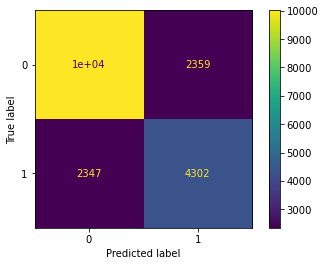

In [23]:
cm = confusion_matrix(y_test, y_pred, labels=xgbc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgbc.classes_)
disp.plot()

## Feature importances and SHAP values

In [24]:
# Feature importances:
importances = xgbc.feature_importances_

sorted_indices = np.argsort(importances)[::-1][:10]
 
indices = importances.argsort()[::-1][:10] # get the indices of the top 10 most important features
for i in indices:
    print(f"{i+1}. {X_train.columns[i]}: {round(importances[i], 2)}")


7. PAGERANK: 0.3199999928474426
6. stations_count: 0.18000000715255737
5. morning_rush: 0.09000000357627869
4. dep_hour_origin: 0.07000000029802322
8. leaves_falling: 0.07000000029802322
9. summer_vacation: 0.05999999865889549
2. weekend: 0.029999999329447746
1. YEAR_DEP_2023: 0.029999999329447746
13. relative_humidity: 0.029999999329447746
11. temperature: 0.029999999329447746


In [25]:
# Create an explainer object for the random forest classifier
tree_explainer = shap.TreeExplainer(xgbc)

# Calculate the SHAP values for a single instance
shap_values = tree_explainer.shap_values(X_test)

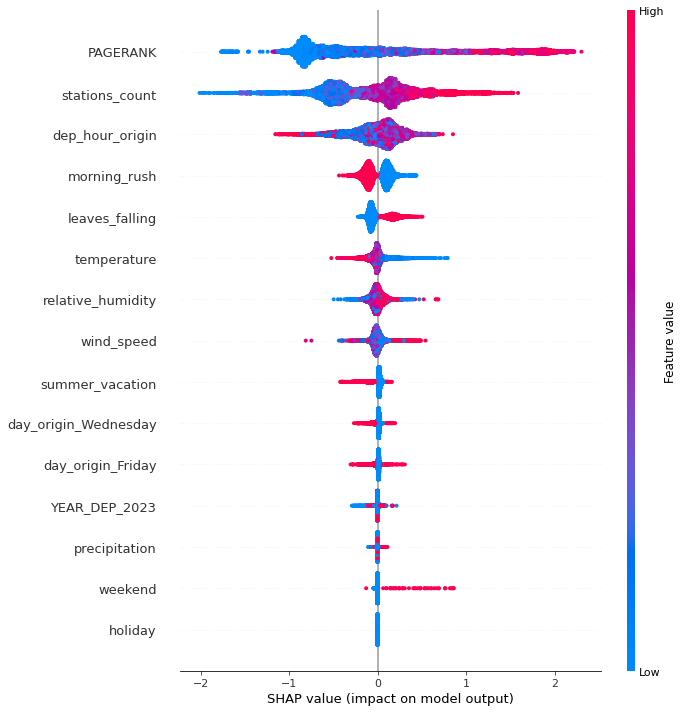

<Figure size 432x288 with 0 Axes>

In [26]:
# get summary plot
shap.summary_plot(shap_values, X_test, max_display=20, plot_size=(10, 10))

plt.tight_layout()

In [27]:
# Create an explainer object for the random forest classifier
tree_explainer = shap.TreeExplainer(xgbc)

# Calculate the SHAP values for a single instance
shap_values = tree_explainer.shap_values(X_test)

i = 45
print(f"Class: {y_test[i]}")
shap.force_plot(tree_explainer.expected_value, shap_values[i,:], X_test.iloc[i,:], link="logit")

Class: 1
